# Статистический анализ данных сервиса аренды самокатов GoFast

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

***Цель исследования***:
1. Описать и визуализировать информацию о пользователях и поездках
2. Подсчитать помесячную выручку для пользователей
3. Проверить гипотезы продакт-менеджеров, которые они хотят использовать для увеличения количества пользователей с подпиской
4. Построить распределения и проанализировать раздачу промокодов и рассылку push-уведомлений

***Ход исследования***:
1. Получим данные из исходных датасетов о пользователях ('datasets/users_go.csv'), подписках ('datasets/subscriptions_go.csv') и поездках ('datasets/rides_go.csv').
2. Обработаем исходные данные: поищем в них ошибки, пропуски и дубликаты, в случае необходимости исправим.
3. Проведем исследование: 
- частоты встречаемости городов 
- соотношения пользователей с подпиской и без
- возраста пользователей
- расстояние пользователей за поездку
- продолжительности поездок
4. Объеденим данные в один датафрейм, затем сделаем 2 отдельных датафрейма для пользователей с подписками и без, визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий
5. Посчитаем выручку
6. Проверем гипотезы о пользователях, полученные от продакт-менеджеров
7. Построим для раздачи промокодов и рассылки push-уведомлений

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

#### Шаг 1. Загрузка данных

In [2]:
try:
    users_go = pd.read_csv('/datasets/users_go.csv')
    print('Код выполняется на платформе')
except FileNotFoundError:
    users_go = pd.read_csv('datasets/users_go.csv')
    print('Код выполняется локально')

Код выполняется локально


In [3]:
try:
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
    print('Код выполняется на платформе')
except FileNotFoundError:
    subscriptions_go = pd.read_csv('datasets/subscriptions_go.csv')
    print('Код выполняется локально')

Код выполняется локально


In [4]:
try:
    rides_go = pd.read_csv('/datasets/rides_go.csv')
    print('Код выполняется на платформе')
except FileNotFoundError:
    rides_go = pd.read_csv('datasets/rides_go.csv')
    print('Код выполняется локально')

Код выполняется локально


In [5]:
print(users_go.info())
users_go.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [6]:
print(subscriptions_go.info())
subscriptions_go.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
print(rides_go.info())
rides_go.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Считали данные из файлов, информация выглядит полной, но далее займемся ее предобработкой: поищем пропуски, дубликаты, нулевые значения.

#### Шаг 2. Предобработка данных

##### Просмотр информации о данных, приведение к нужному типу 

In [8]:
users_go.info()
users_go

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


Информация о пользователях полная, без пропусков, что очень хорошо. user_id конечно в int64, а не int32, но места датафрейм не занимает, преобразовывать не будем. 

In [9]:
subscriptions_go.info()
subscriptions_go

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Это вообще информация о подписках, места не занимает, данные видны сразу все, ошибок нет

In [10]:
rides_go.info()
rides_go

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


Информация о поездках полная, без пропусков, что очень хорошо. user_id конечно в int64, а не int32, но места датафрейм не занимает, преобразовывать не будем. А вот дату из объекта переделаем в формат дата время.

In [11]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [12]:
rides_go['month'] = pd.DatetimeIndex(rides_go['date']).month
rides_go.info()
rides_go

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


In [13]:
pd.DatetimeIndex(rides_go['date']).year.unique()

Int64Index([2021], dtype='int64', name='date')

##### Поиск пропущенных значений и дубликатов

Пропусков нет, поищем дубликаты

In [14]:
print(len(users_go))
print(users_go.nunique())

1565
user_id              1534
name                  194
age                    29
city                    8
subscription_type       2
dtype: int64


In [15]:
users_go = users_go.drop_duplicates().reset_index(drop=True)
users_go.info()
print("\n", len(users_go), "\n")
print(users_go.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB

 1534 

user_id              1534
name                  194
age                    29
city                    8
subscription_type       2
dtype: int64


In [16]:
print(len(rides_go))
print(rides_go.nunique())

18068
user_id      1534
distance    18068
duration    17974
date          364
month          12
dtype: int64


Дубликаты были найдены только в информации о пользователях и удалены. Индексы в датафрейме об информации о пользователях сброшены.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [17]:
users_go['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Text(0, 0.5, 'Число пользователей')

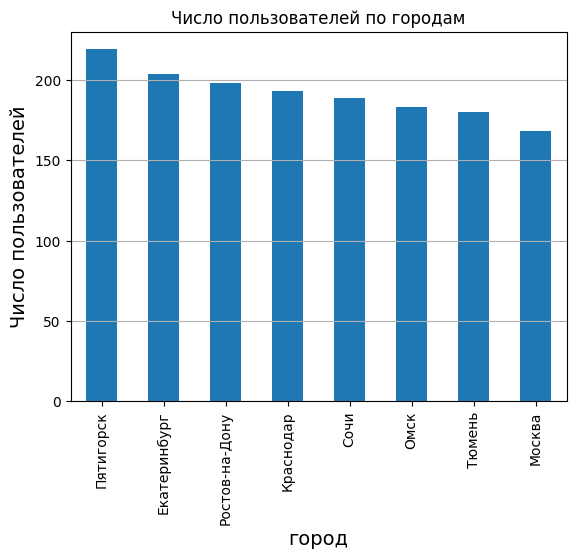

In [18]:
users_go['city'].value_counts().plot(kind='bar').grid(axis='y')
plt.title("Число пользователей по городам")
plt.xlabel('город', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

По полученному графику видно, что больше всего пользователей из г. Пятигорск (219 пользователей), меньше всего - из Москвы (168 пользователей). 

##### Соотношение пользователей с подпиской и без подписки

In [19]:
users_go['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

Text(0.5, 1.0, 'Число пользователей по подпискам в %')

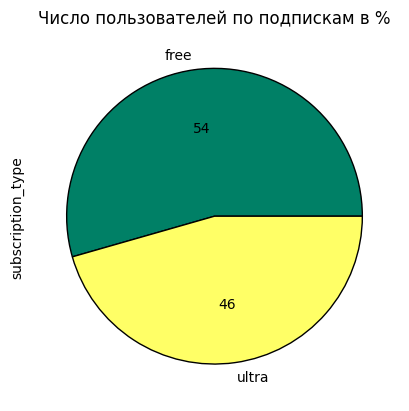

In [20]:
sub_user_distr = users_go['subscription_type'].value_counts()
sub_users = sub_user_distr['ultra']
non_sub_users = sub_user_distr['free']
all_users = sub_users + non_sub_users
autopact_values = [sub_users, non_sub_users]
sub_user_distr.plot(kind='pie',
                    colormap='summer',
                    autopct='%.0f',
                    wedgeprops = {"edgecolor" : "black", 
                                  'linewidth': 1, 
                                  'antialiased': True})
plt.title("Число пользователей по подпискам в %")

In [21]:
print(f'''Количество пользователей составляет:
с подпиской ультра: {round(sub_users / all_users * 100, 2)}% ({sub_users} пользователей)
без подписки: {round(non_sub_users / all_users * 100, 2)}% ({non_sub_users} пользователей)
Пользователей без подписки на {round(100 * (non_sub_users - sub_users) / non_sub_users, 2)}% больше.''')
sub_user_distr

Количество пользователей составляет:
с подпиской ультра: 45.57% (699 пользователей)
без подписки: 54.43% (835 пользователей)
Пользователей без подписки на 16.29% больше.


free     835
ultra    699
Name: subscription_type, dtype: int64

Получилось соотношение пользователей, показанное на диаграмме. Пользователей с подпиской 46%, без - 54%.

##### Возраст пользователей

In [22]:
print(users_go['age'].nunique(),
      users_go['age'].max() - users_go['age'].min())

29 31


Text(0, 0.5, 'Число пользователей')

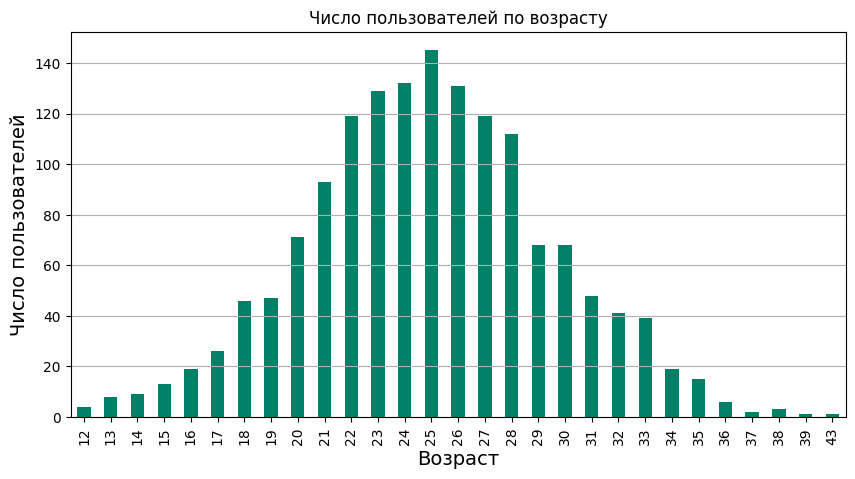

In [23]:
users_go['age'].value_counts().sort_index().plot(kind='bar', colormap='summer', figsize=(10,5)).grid(axis='y')
plt.title("Число пользователей по возрасту")
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

Можем наблюдать большинство пользователей в возрасте 22-27 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


Text(0, 0.5, 'Число пользователей')

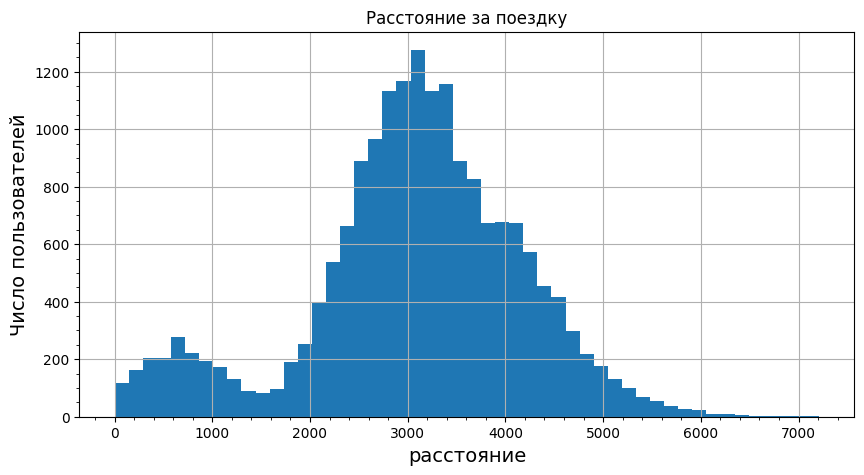

In [24]:
print(rides_go['distance'].describe())
rides_go['distance'].hist(bins=50, figsize=(10,5)).minorticks_on()
plt.title("Расстояние за поездку")
plt.xlabel('расстояние', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

In [25]:
rides_go[rides_go['distance'] < 100]['distance'].describe()

count    78.000000
mean     57.404311
std      28.569031
min       0.855683
25%      32.424553
50%      63.859570
75%      84.357564
max      99.744889
Name: distance, dtype: float64

Есть пользователи, которые проехали меньше 100 м, то есть скорее всего взяли самокат и отказались от поездки. Таких всего 78. При этом можно наблюдать два пика - в районе 700м и в районе 3км. На эти расстояния пользователи чаще всего берут самокаты.

##### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


Text(0, 0.5, 'Число пользователей')

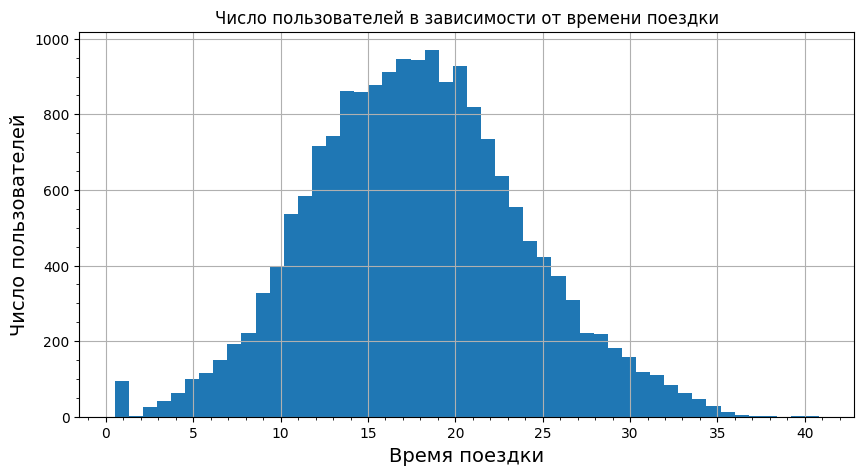

In [26]:
print(rides_go['duration'].describe())
rides_go['duration'].hist(bins=50, figsize=(10,5)).minorticks_on()
plt.title("Число пользователей в зависимости от времени поездки")
plt.xlabel('Время поездки', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

In [27]:
rides_go[rides_go['duration'] < 2.01]['duration'].describe()

count    95.0
mean      0.5
std       0.0
min       0.5
25%       0.5
50%       0.5
75%       0.5
max       0.5
Name: duration, dtype: float64

In [28]:
rides_go[rides_go['duration'] < 2.01]['distance'].describe()

count      95.000000
mean     5113.176549
std       658.254104
min      4030.308008
25%      4611.510820
50%      5052.769411
75%      5488.459099
max      7211.007745
Name: distance, dtype: float64

На данном графике виден уже только один пик, на времени, равном 17-19 мин. Второго пика, как на графике длины поездки, не наблюдается. Это скорее всего связано с тем, что пользователи тратят время на поиск самоката, его парковку и прочие вещи. Также виден стобик на гистограмме около 0. Его мы рассмотрели отдельно, и в нем пользователи берут самокат и почти сразу же возвращают, но при этом проезжают каким-то образом минимум 4км. Видимо, здесь ошибка в данных, поэтому эти строки лучше удалить. Из-за этого придется заново построить графики.

In [29]:
rides_go = rides_go[rides_go['duration'] > 2]

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64


Text(0, 0.5, 'Число пользователей')

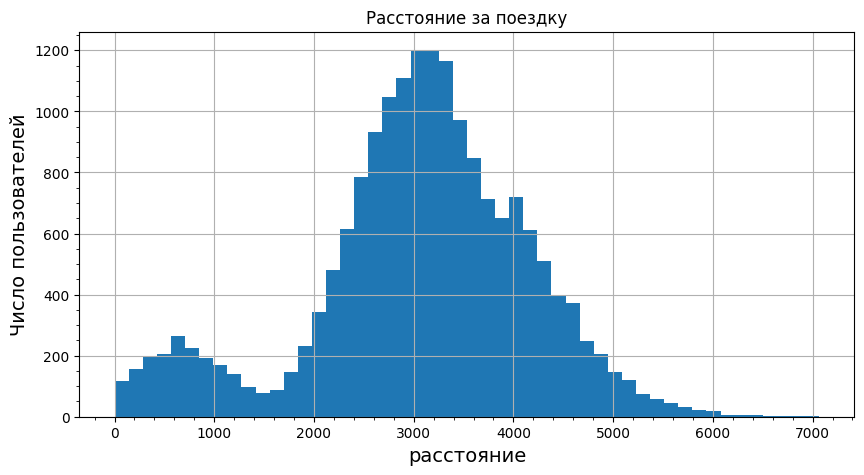

In [30]:
print(rides_go['distance'].describe())
rides_go['distance'].hist(bins=50, figsize=(10,5)).minorticks_on()
plt.title("Расстояние за поездку")
plt.xlabel('расстояние', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64


Text(0, 0.5, 'Число пользователей')

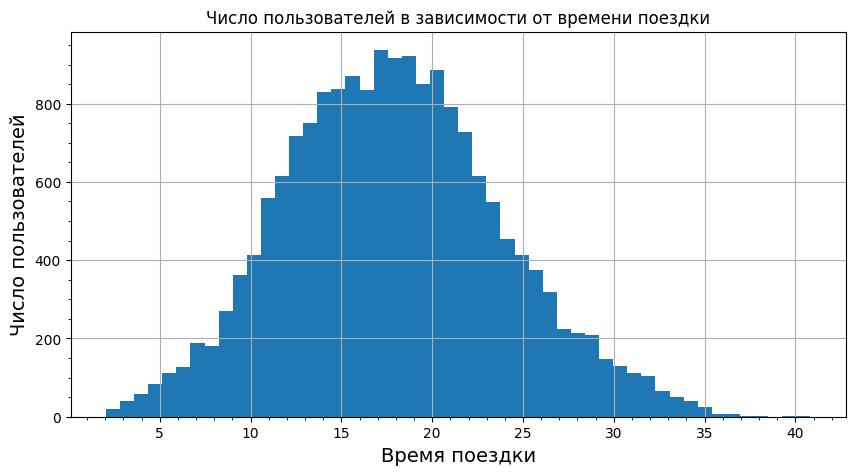

In [31]:
print(rides_go['duration'].describe())
rides_go['duration'].hist(bins=50, figsize=(10,5)).minorticks_on()
plt.title("Число пользователей в зависимости от времени поездки")
plt.xlabel('Время поездки', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

Вид графика для расстояния поездок почти не изменился, а вот на графике со временем мы убрали часть неверных данных и график стал лучше. 

Оба распределения - как расстояния, так и времени, похожи на нормальное распределение, хотя у графика расстояния имеется небольшой пик в начале, что говорит о том, что могут присутствовать выбросы в данных.

Вывод: графики по пользователям, построенные ранее - говорят о том, что в основном пользуются люди от 21 до 28 лет, больщинство в Пятигорске, меньше всего в Москве, пользователей без подписки - больше, но не намного.

Text(0.5, 1.0, 'Диаграмма размаха для расстояния поездок')

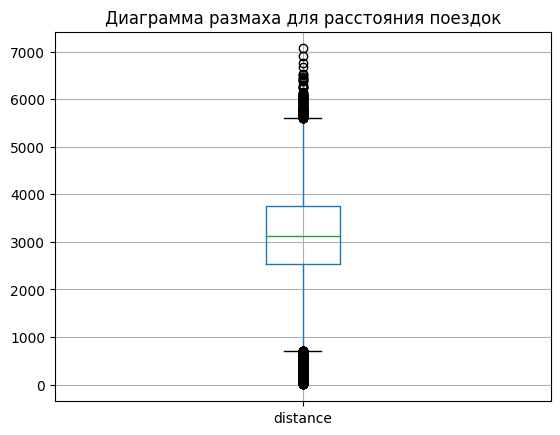

In [32]:
rides_go.boxplot('distance')
plt.title("Диаграмма размаха для расстояния поездок")

Text(0.5, 1.0, 'Диаграмма размаха для длительности поездок')

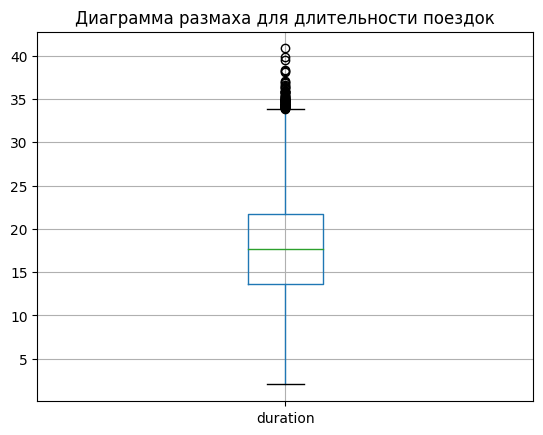

In [33]:
rides_go.boxplot('duration')
plt.title("Диаграмма размаха для длительности поездок")

Также привели диаграммы размаха, по котором видно, что для поездок имеется двольно много значений, выходящих за рамки 1,5 квартильного размаха. Это говорит о том что довольно много пользователей, сильно отличающихся от основной массы. По диаграмме размаха времени поездок выбросы видны только в сторону увеличения времени. Это связано с тем, что данные по поездкам на очень короткое время были удалены в связи с их некорректностью. Удаленные данные попали бы на эту диаграмму в нижнюю часть. 

#### Шаг 4. Объединение данных

In [34]:
rides_go['user_id'].nunique()

1534

In [35]:
users_go['user_id'].nunique()

1534

In [36]:
subscriptions_go['subscription_type'].nunique()

2

In [37]:
users_go['subscription_type'].nunique()

2

In [38]:
len(rides_go)

17973

In [39]:
all_data = (rides_go.merge(users_go, on='user_id', how='left')
                    .merge(subscriptions_go, on='subscription_type', how='left')
)
all_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [40]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Датафреймы хорошо объединились, нулевых значений нет, значит в процессе объединения были найдены все данные по ключам были найдены в объединяемых датафреймах. Количество строк не поменялось, и не могло поменяться в данном случае, так как ключами были сделаны значения в левых датафреймах.

In [41]:
data_subscribed = all_data.query('subscription_type == "ultra"')
data_subscribed

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


In [42]:
data_not_subscribed = all_data.query('subscription_type != "ultra"')
data_not_subscribed

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


Text(0, 0.5, 'Число пользователей')

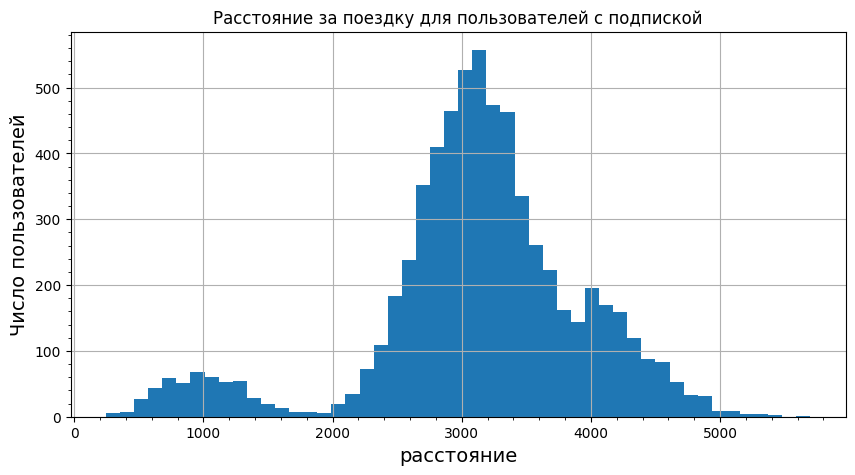

In [43]:
print(data_subscribed['distance'].describe())
data_subscribed['distance'].hist(bins=50, figsize=(10,5)).minorticks_on()
plt.title("Расстояние за поездку для пользователей с подпиской")
plt.xlabel('расстояние', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


Text(0, 0.5, 'Число пользователей')

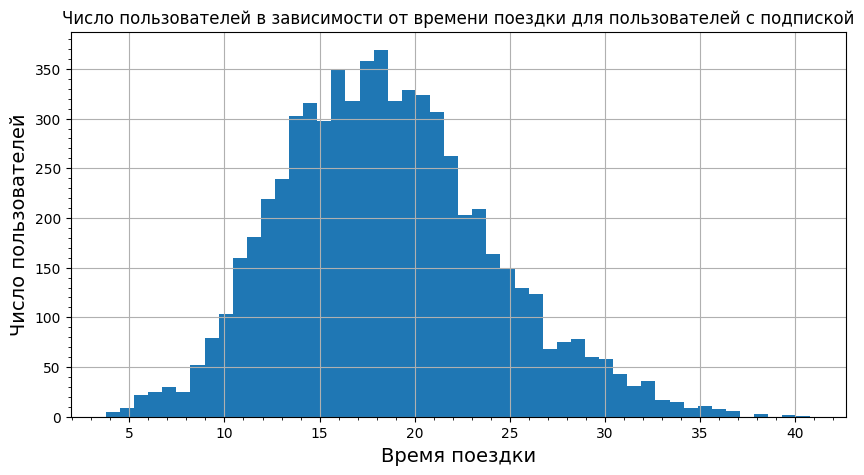

In [44]:
print(data_subscribed['duration'].describe())
data_subscribed['duration'].hist(bins=50, figsize=(10,5)).minorticks_on()
plt.title("Число пользователей в зависимости от времени поездки для пользователей с подпиской")
plt.xlabel('Время поездки', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64


Text(0, 0.5, 'Число пользователей')

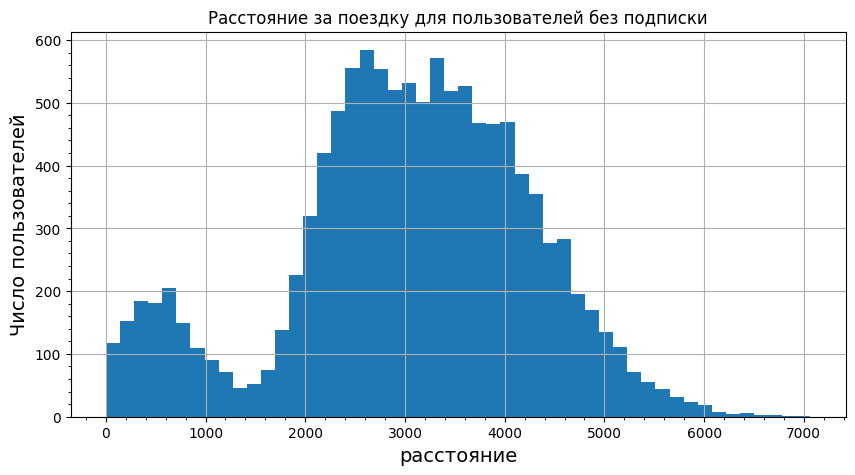

In [45]:
print(data_not_subscribed['distance'].describe())
data_not_subscribed['distance'].hist(bins=50, figsize=(10,5)).minorticks_on()
plt.title("Расстояние за поездку для пользователей без подписки")
plt.xlabel('расстояние', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64


Text(0, 0.5, 'Число пользователей')

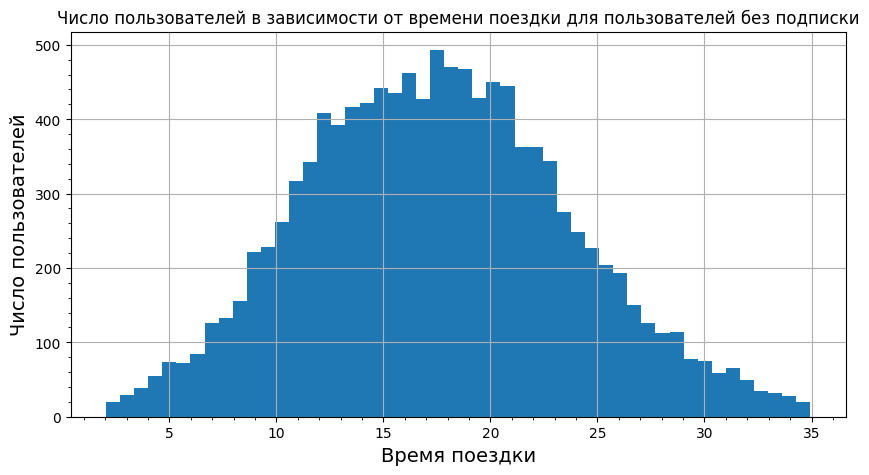

In [46]:
print(data_not_subscribed['duration'].describe())
data_not_subscribed['duration'].hist(bins=50, figsize=(10,5)).minorticks_on()
plt.title("Число пользователей в зависимости от времени поездки для пользователей без подписки")
plt.xlabel('Время поездки', fontsize=14)
plt.ylabel('Число пользователей', fontsize=14)

На данном этапе были объединены все данные в один датайрейм, а похже разделены на 2: пользователи с подпиской и без. Есть информация о 6500 поездках пользователей с подпиской и 11473 поездках пользователей без подписки. У пользователей с подпиской есть два пика на графике - около 1 км (чуть меньше 100 поездок) и около 3.2 км (около 500 поездок). Время поездки у них имеет только 1 пик в районе 15-20 минут. У пользователей без подписки ситуация очень похожа, но первый пик в районе 600-800м (примерно 200 поездок) и второй в районе также 3 км (примерно 500-600 поездок) хотя и имеет две вершины при дистанции 2500 м и 3500 м. Время поездки у них имеет также 1 пик в районе 15-20 минут.

#### Шаг 5. Подсчёт выручки

In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Нулевых значений в датафрейме нет, можем приступать к расчетам

In [48]:
all_data['duration'] = np.ceil(all_data['duration']).astype('int32')
data_subscribed['duration'] = np.ceil(data_subscribed['duration']).astype('int32')
data_not_subscribed['duration'] = np.ceil(data_not_subscribed['duration']).astype('int32')
all_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,3781.098080,20,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
17969,1534,2840.423057,22,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
17970,1534,3826.185507,19,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
17971,1534,2902.308661,17,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [49]:
all_data_revenue = all_data.pivot_table(index=['month', 'user_id'],
                                        values=['distance', 'duration'],
                                        aggfunc={'distance':'sum', 'duration':'sum', 'user_id':'count'})
all_data_revenue = all_data_revenue.rename(columns={'user_id':'quantity'})
all_data_revenue = all_data_revenue.reset_index()
print(all_data_revenue.info())
all_data_revenue

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11300 entries, 0 to 11299
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   month     11300 non-null  int64  
 1   user_id   11300 non-null  int64  
 2   distance  11300 non-null  float64
 3   duration  11300 non-null  int32  
 4   quantity  11300 non-null  int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 397.4 KB
None


,month,user_id,distance,duration,quantity
0,1,1,7027.511294,42,2
1,1,3,3061.777147,13,1
2,1,5,3914.646990,13,1
3,1,7,6478.080979,28,2
4,1,12,3577.151148,33,1
...,...,...,...,...,...
11295,12,1525,4597.854350,34,1
11296,12,1526,3644.121544,23,1
11297,12,1528,3998.569324,11,1
11298,12,1532,6111.889853,42,2


In [50]:
sub_minute_price = subscriptions_go.loc[subscriptions_go['subscription_type'] == 'ultra']['minute_price'].iloc[0]
sub_price = subscriptions_go.loc[subscriptions_go['subscription_type'] == 'ultra']['subscription_fee'].iloc[0]
sub_start_price = subscriptions_go.loc[subscriptions_go['subscription_type'] == 'ultra']['start_ride_price'].iloc[0]
free_minute_price = subscriptions_go.loc[subscriptions_go['subscription_type'] == 'free']['minute_price'].iloc[0]
free_price = subscriptions_go.loc[subscriptions_go['subscription_type'] == 'free']['subscription_fee'].iloc[0]
free_start_price = subscriptions_go.loc[subscriptions_go['subscription_type'] == 'free']['start_ride_price'].iloc[0]
subscribed_users = set(data_subscribed['user_id'])
def revenue_count(row):
    duration = row['duration']
    quantity = row['quantity']
    user_id = row['user_id']
    if user_id in subscribed_users:
        total_price = duration * sub_minute_price + quantity * sub_start_price + sub_price
    else:
        total_price = duration * free_minute_price + quantity * free_start_price + free_price
    return total_price

all_data_revenue['revenue'] = all_data_revenue.apply(revenue_count, axis=1)
all_data_revenue

,month,user_id,distance,duration,quantity,revenue
0,1,1,7027.511294,42,2,451.0
1,1,3,3061.777147,13,1,277.0
2,1,5,3914.646990,13,1,277.0
3,1,7,6478.080979,28,2,367.0
4,1,12,3577.151148,33,1,397.0
...,...,...,...,...,...,...
11295,12,1525,4597.854350,34,1,322.0
11296,12,1526,3644.121544,23,1,234.0
11297,12,1528,3998.569324,11,1,138.0
11298,12,1532,6111.889853,42,2,436.0


Создали датафрейм с затратами пользователей по месяцам. Траты пользователей добавили в колонку revenue. Далее проанализируем эти данные.

#### Шаг 6. Проверка гипотез

##### Затраты времени на поездку

In [51]:
print(data_subscribed['duration'].describe())
print(data_not_subscribed['duration'].describe())

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64
count    11473.000000
mean        18.030855
std          6.166175
min          3.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64


Среднее время поездки за одну сессию больше у пользователей с подпиской - примерно на 1 минуту. Также как и медиана поездки. Далее проверим гипотезу, используя односторонние гипотезы для средних двух генеральных совокупностей. 

Нулевая гипотеза: время поездок пользователей одинаково. 

Альтернативная гипотеза: среднее время поездки за одну сессию больше у пользователей с подпиской. 

Альфа (уровень значимости), использованное здесь, будет использоваться и вдальнейшем - на уровне 5%.

In [52]:
alpha = 0.05
results = st.ttest_ind(data_subscribed['duration'], data_not_subscribed['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 8.577910347796266e-28
Отвергаем нулевую гипотезу


Проведя тест, отвергаем нулевую гипотезе о равном среднем времени - получается, что пользователи с подпиской тратят больше времени на поездки.

##### Проверка гипотоезы: расстояние за поездку не превышает 3130м

In [53]:
data_subscribed['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

 Нулевая гипотеза: расстояние одной поездки 3130м. Альтернативная гипотеза: расстояние превышает 3130м.

In [54]:
interested_value = 3130
results = st.ttest_1samp(data_subscribed['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


В результате делаем вывод, что пользователи с подпиской в среднем проезжают около 3130м, то есть расстояние не превышает 3130м с очень высокой вероятностью.

##### Затраты пользователей

 Нулевая гипотеза: затраты пользователей одинаковы. Альтернативная гипотеза: затраты с подпиской больше.

In [55]:
all_data_revenue['subscription_type'] = all_data_revenue.apply(lambda row:
                                                               'ultra' if row['user_id'] in subscribed_users 
                                                               else 'free',
                                                               axis=1)
print(all_data_revenue.query("subscription_type == 'ultra'")['revenue'].describe())
print(all_data_revenue.query("subscription_type == 'free'")['revenue'].describe())

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue, dtype: float64
count    6767.000000
mean      329.332644
std       183.268419
min        74.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue, dtype: float64


In [56]:
results = st.ttest_ind(all_data_revenue.query("subscription_type == 'ultra'")['revenue'],
                       all_data_revenue.query("subscription_type == 'free'")['revenue'],
                       alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.0314113674862713e-30
Отвергаем нулевую гипотезу


Получилось значение около нуля - это говорит о том что затраты с подпиской наверняка больше, чем без нее.

#### Шаг 7. Распределения

##### Поиск минимального числа промокодов

In [57]:
target_p = 0.95
target = 100
p = 0.1
n = 100
result = 0
while result < target_p:
    distr = st.binom(n, p)
    result = 1 - distr.cdf(target)
    n += 1
print(n, distr.ppf(1 - target_p), 1 - distr.cdf(target))

1173 101.0 0.9504520478979693


Таким образом, если дать промокод на подписку 1170 пользователем 100 из них с вероятностью 95% продлят подписку. Проверим эти значения на биномиальном распределении. Это распределение можно было аппроксимировать нормальным. Покажем это на примере ниже.

In [58]:
p = 0.1
n = 100
mu = p * n
sigma = (n * p * (1 - p))**0.5
distr = st.norm(mu, sigma)
print(f"""mu:{mu}
sigma:{sigma}
mu - 3 * sigma: {mu - 3 * sigma}
mu + 3 * sigma: {mu + 3 * sigma}
n:{n}""")

mu:10.0
sigma:3.0
mu - 3 * sigma: 1.0
mu + 3 * sigma: 19.0
n:100


In [59]:
target_p = 0.95
target = 100
p = 0.1
n = 100
result = 0
while result < target_p:
    mu = n * p
    sigma = (n * p * (1 - p))**0.5
    distr = st.norm(mu, sigma)
    result = 1 - distr.cdf(target)
    n += 1
print(n, distr.ppf(1 - target_p), 1 - distr.cdf(target))

1170 100.02841955223583 0.9502851068730583


Проверили условия аппроксимации биномиального распределения нормальным для 100 (их конечно будет больше, но нам надо узнать необходимое количество, поэтому начальной точкой отсчета будет 100). Оно не вышло за требуемый диапозон для нормального распределения и можно использовать его.

In [60]:
distr = st.binom(n, p)
print(n, distr.ppf(1 - target_p), 1 - distr.cdf(target))

1170 100.0 0.9484850832625835


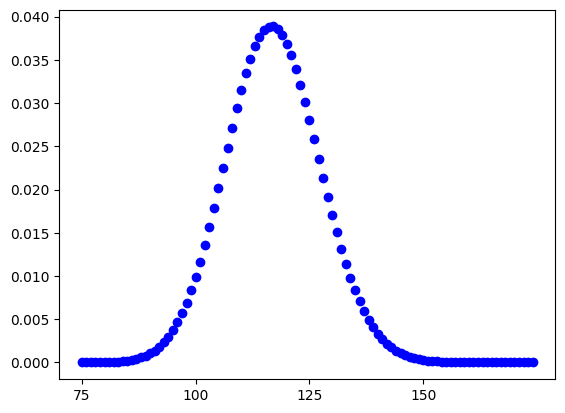

In [61]:
graph = []
for i in range(75, 175):
    a = distr.pmf(i)
    graph.append(a)    
plt.plot(range(75, 175), graph, 'bo')
plt.xticks(range(75, 175, 25))
plt.show() 

Как мы можем видеть, для расчетов с биномиальным распределением мы получили 1173 пользователя для достижения нашей цели: получить 100 подписок с вероятностью 95%. При аппроксимации биномиального распределения нормальным мы получили, что необходимо дать 1170 бесплатных подписок, что почти соответствует результату биномиального распределения.


##### Оценка вероятности открытия уведомления

In [62]:
p_open = 0.4
n_notifications = 1000000
n_open = 399500

Так как значение n велико, а вероятность близка к 0.5, воспользуемся нормальной аппроксимацией.

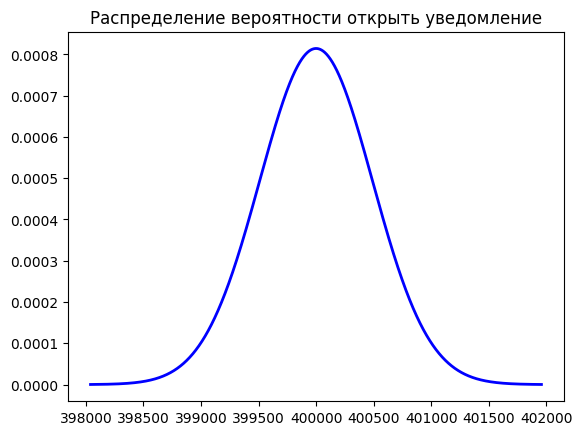

In [63]:
mu = n_notifications * p_open
sigma =  (n_notifications * p_open * (1 - p_open))**0.5
left = int(mu - 4 * sigma)
right = int(mu + 4 * sigma)
x = range(left, right)
norm_plot = plt.subplot()
norm_plot.plot(x, st.norm.pdf(x, mu, sigma), 'b-', lw=2)
x_ticks = range(int(mu - 3 * sigma), int(mu + 3 * sigma))
plt.title("Распределение вероятности открыть уведомление")
plt.show()

In [64]:
print(f'вероятность, что уведомление откроют не более 355,9 тыс. пользователей: {st.norm.cdf(n_open, mu, sigma)}')

вероятность, что уведомление откроют не более 355,9 тыс. пользователей: 0.15371708296369768


Таким образом, были рассмотрены два биномиальных распределения и получены результаты: нужно отправить промокод на бесплатную подписку 1173 людям, чтобы получить желаемый результат в 100 и более подписок с вероятностью 95%; вероятность, что уведомление откроют не более 355,9 тыс. пользователей 15,4%

#### Общий вывод

**Общий вывод**:

В данной работе был проведен статистический анализ данных о пользователях самоката. 
Были получены данные из исходных датасетов о пользователях, подписках и поездках. Затем они были обработаны: устранены ошибки, пропуски и дубликаты.
Далее в результате проведенных исследований получено, что:
- Больше всего в данных пользователей из г. Пятигорск (219 пользователей), меньше всего - из Москвы (168 пользователей). 
- Пользователей без подписки больше на 16%, чем с подпиской (54% - без подписки, 46% с подпиской).
- В полученных нами данных можем наблюдать большинство пользователей в возрасте 22-27 лет.
- Основная часть поездок занимает от 2500 до 3800 метров. Очень редко пользователи ездят на расстояние более 5км.
- Основная часть поездок занимает от 14 до 22 минут. Очень редко пользователи ездят более 30 минут.
Для каждой величины были построены соответствующие графики/гистограммы.

Потом датафреймы были объединены в один и подсчитана выручка для каждого пользователя по месяцам, а также визуализирована информация о дистанции и времени поездок для пользователей двух категорий: с подпиской и без нее. 

После этого были проверены гипотезы продакт-менеджеров и получили результат:
- Пользователи с подпиской тратят больше времени на поездки.
- Оптимальное расстояние с точки зрения износа в 3130м больше, чем пользователи проезжают в среднем за одну поездку.
- Затраты пользователей с подпиской больше, чем без нее.

Затем были построены распределения для достижения целей менеджеров и получены следующие результаты:
- Для выполнения плана в 100 продленных  подписок после их бесплатной раздачи с вероятностью 95% надо дать бесплатную подписку 1173 пользователям, при условии, что подписку в среднем продлевают 10% пользователей.
- Если разослать push-уведомление 1млн клиентов, то при условии, что его открывают 40% пользователей, то более 399,5тыс. пользователей не откроют это уведомление с вероятностью 15,4%.

Общая рекомендация: попробовать увеличить количество пользователей с подписками - так будет выгоднее для компании.